In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("data/performance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [26]:
target = "math score"
X = df.drop(target, axis=1)
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [11]:
categorical_feature = (
    X.select_dtypes(include=[object]).apply(lambda col: col.unique().tolist()).to_dict()
)
categorical_feature

{'gender': ['female', 'male'],
 'race/ethnicity': ['group B', 'group C', 'group A', 'group D', 'group E'],
 'parental level of education': ["bachelor's degree",
  'some college',
  "master's degree",
  "associate's degree",
  'high school',
  'some high school'],
 'lunch': ['standard', 'free/reduced'],
 'test preparation course': ['none', 'completed']}

In [12]:
y = df[target]
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

In [18]:
num_features = X.select_dtypes(exclude=[object]).columns.tolist()
cat_features = X.select_dtypes(include=[object]).columns.tolist()

In [19]:
num_features

['reading score', 'writing score']

In [20]:
cat_features

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("StandardScaler", numeric_transformer, num_features),
        ("OneHotEncoder", oh_transformer, cat_features),
    ]
)

In [28]:
X = preprocessor.fit_transform(X)

In [29]:
X.shape

(1000, 19)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
def evaluate_model(acutal: np.array, predicted: np.array) -> dict:
    mse = mean_squared_error(acutal, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(acutal, predicted)
    mae = mean_absolute_error(acutal, predicted)
    mape = mean_absolute_percentage_error(acutal, predicted)
    return {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae, "mape": mape}

(800, 19)

In [38]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=0),
    "XGBRegressor": XGBRegressor(),
}

model_list = []
r2_list = []

for i in models.keys():
    model = models[i]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_test_r2 = r2_score(y_test, y_pred)
    model_list.append(i)
    r2_list.append(model_test_r2)

    print(f"Model: {i}")
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print("=" * 35)

Model: LinearRegression
- R2 Score: 0.8804
Model: Ridge
- R2 Score: 0.8806
Model: Lasso
- R2 Score: 0.8253
Model: KNeighborsRegressor
- R2 Score: 0.7838
Model: RandomForestRegressor
- R2 Score: 0.8523
Model: AdaBoostRegressor
- R2 Score: 0.8507
Model: CatBoostRegressor
- R2 Score: 0.8516
Model: XGBRegressor
- R2 Score: 0.8212


In [39]:
pd.DataFrame(
    list(zip(model_list, r2_list)), columns=["Model Name", "R2_Score"]
).sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score
1,Ridge,0.880593
0,LinearRegression,0.880433
4,RandomForestRegressor,0.852344
6,CatBoostRegressor,0.851632
5,AdaBoostRegressor,0.850673
2,Lasso,0.825320
7,XGBRegressor,0.821221
3,KNeighborsRegressor,0.783770


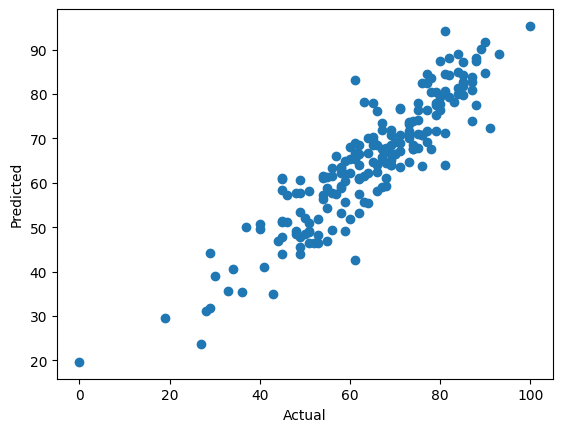

In [40]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")

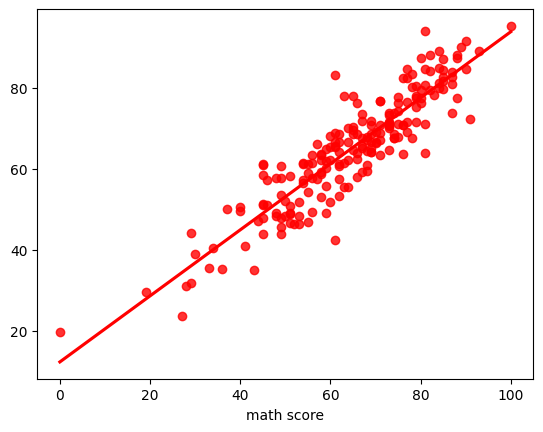

In [44]:
sns.regplot(x=y_test, y=y_pred, ci=None, color="red")